In [5]:
#!/usr/bin/env python
# coding: utf-8
import torch
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapterPlusXL
from ip_adapter.custom_pipelines import StableDiffusionXLCustomPipeline
import wandb
from ip_adapter.utils import register_cross_attention_hook, get_net_attn_map, attnmaps2images

/root/anaconda3/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [22]:
base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "models/image_encoder/"
vae_model_path = "stabilityai/sd-vae-ft-mse"
ip_ckpt = "sdxl_models/ip-adapter-plus-face_sdxl_vit-h.bin" # a experimental version
device = "cuda"

In [16]:
pipe = StableDiffusionXLCustomPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    add_watermarker=False,
)
pipe.unet = register_cross_attention_hook(pipe.unet)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
pipe.unet = register_cross_attention_hook(pipe.unet)

In [23]:
ip_model = IPAdapterPlusXL(pipe, image_encoder_path, ip_ckpt, device, num_tokens=16)
# load ip-adapter

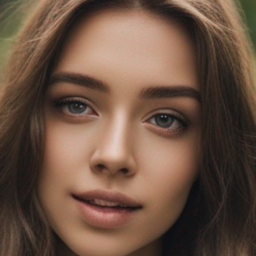

In [24]:
face_image = Image.open("assets/images/ai_face.png")
# generate image
prompt = "photo of a beautiful girl wearing casual shirt in a garden"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"
face_image.resize((256, 256))


  0%|          | 0/30 [00:00<?, ?it/s]

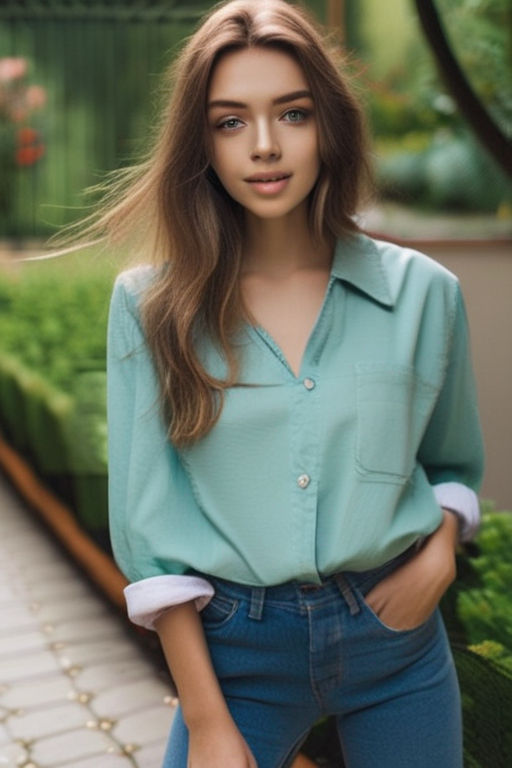

In [25]:
images = ip_model.generate(
        pil_image=face_image,
        prompt=prompt,
        num_samples=1,
        num_inference_steps=30,
        width=512, height=768,
        seed=420)
images[0]

In [26]:
attn_maps = get_net_attn_map((768, 512))
print(attn_maps.shape)
attn_hot = attnmaps2images(attn_maps)

torch.Size([16, 768, 512])


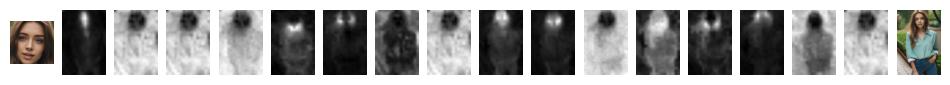

In [27]:
import matplotlib.pyplot as plt
#axes[0].imshow(attn_hot[0], cmap='gray')
display_images = [face_image] + attn_hot + [images[0]]
fig, axes = plt.subplots(1, len(display_images), figsize=(12, 4))
for axe, image in zip(axes, display_images):
    axe.imshow(image, cmap='gray')
    axe.axis('off')
plt.show()